In [1]:
#importing standard libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
#Importing Keras so that I can apply CNN
import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

#importing libraries for data processing
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
import os, re, csv, math, codecs

sns.set_style("whitegrid")
np.random.seed(0)
#Setting path for kaggle data.
DATA_PATH = '../input/'
EMBEDDING_DIR = '../input/'

MAX_NB_WORDS = 100000
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

Using TensorFlow backend.


In [2]:
len(stop_words)

191

In [3]:
stop_words_2 = set(stopwords.words('spanish'))

In [4]:
stop_words_2

{'a',
 'al',
 'algo',
 'algunas',
 'algunos',
 'ante',
 'antes',
 'como',
 'con',
 'contra',
 'cual',
 'cuando',
 'de',
 'del',
 'desde',
 'donde',
 'durante',
 'e',
 'el',
 'ella',
 'ellas',
 'ellos',
 'en',
 'entre',
 'era',
 'erais',
 'eran',
 'eras',
 'eres',
 'es',
 'esa',
 'esas',
 'ese',
 'eso',
 'esos',
 'esta',
 'estaba',
 'estabais',
 'estaban',
 'estabas',
 'estad',
 'estada',
 'estadas',
 'estado',
 'estados',
 'estamos',
 'estando',
 'estar',
 'estaremos',
 'estará',
 'estarán',
 'estarás',
 'estaré',
 'estaréis',
 'estaría',
 'estaríais',
 'estaríamos',
 'estarían',
 'estarías',
 'estas',
 'este',
 'estemos',
 'esto',
 'estos',
 'estoy',
 'estuve',
 'estuviera',
 'estuvierais',
 'estuvieran',
 'estuvieras',
 'estuvieron',
 'estuviese',
 'estuvieseis',
 'estuviesen',
 'estuvieses',
 'estuvimos',
 'estuviste',
 'estuvisteis',
 'estuviéramos',
 'estuviésemos',
 'estuvo',
 'está',
 'estábamos',
 'estáis',
 'están',
 'estás',
 'esté',
 'estéis',
 'estén',
 'estés',
 'fue',
 'f

In [5]:
#load embeddings
embeddings_index = {}
#Have downloaded fastext pretrained embeddings. So loading it here
f = codecs.open('../input/fasttext2/wiki.simple.vec', encoding='utf-8')
print(f)
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    #print(word)
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

1876it [00:00, 9090.05it/s]

111052it [00:13, 8488.49it/s]


In [6]:
train_df = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge' + '/train.csv', sep=',', header=0)

In [7]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [8]:
label_names = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

In [9]:
# separate explanatory and dependent variables
y = train_df[label_names].values

In [10]:
len(y)

159571

In [11]:
raw_docs_train = train_df['comment_text'].tolist()
# split for cross-validation (train-60%, validation 20% and test 20%)

In [12]:
len(raw_docs_train)

159571

In [13]:
num_classes = len(label_names)

print(num_classes)

6


In [14]:
processed_docs_train = []
for doc in tqdm(raw_docs_train):
    tokens = tokenizer.tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))

100%|██████████| 159571/159571 [00:04<00:00, 32900.11it/s]


In [15]:
raw_docs_train[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [16]:
processed_docs_train[0]

'Explanation Why edits made username Hardcore Metallica Fan reverted They vandalisms closure GAs I voted New York Dolls FAC And please remove template talk page since I retired 89 205 38 27'

In [17]:
#Tokenizing data.

tokenizer_train = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer_train.fit_on_texts(processed_docs_train)  #leaky

In [18]:
type(tokenizer_train)

keras_preprocessing.text.Tokenizer

In [19]:
word_seq_train = tokenizer_train.texts_to_sequences(processed_docs_train)
word_index = tokenizer_train.word_index
print("dictionary size: ", len(word_index))

dictionary size:  186531


In [20]:
len(word_seq_train)

159571

In [21]:
train_df['doc_len'] = train_df['comment_text'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(train_df['doc_len'].mean() + train_df['doc_len'].std()).astype(int)

In [22]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,doc_len
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,42
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,18
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,42
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,112
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,13


In [23]:
max_seq_len

168

In [24]:
train_df['doc_len'].mean()

67.86696204197504

In [25]:
   #So here we are padding the sequnce so that I will work ML algorithms because
    #it should have same length
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)

X_train, X_test, y_train, y_test = train_test_split(word_seq_train, y, test_size=0.4, random_state=123)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=123)


In [26]:
word_seq_train[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [27]:
processed_docs_train[0]

'Explanation Why edits made username Hardcore Metallica Fan reverted They vandalisms closure GAs I voted New York Dolls FAC And please remove template talk page since I retired 89 205 38 27'

In [28]:
word_index

{'i': 1,
 'article': 2,
 'wikipedia': 3,
 'the': 4,
 'page': 5,
 'talk': 6,
 'you': 7,
 'please': 8,
 'would': 9,
 'one': 10,
 'like': 11,
 'if': 12,
 'it': 13,
 'see': 14,
 'also': 15,
 'think': 16,
 'know': 17,
 'people': 18,
 'edit': 19,
 'this': 20,
 'articles': 21,
 'use': 22,
 'time': 23,
 'may': 24,
 'user': 25,
 'thanks': 26,
 'even': 27,
 'get': 28,
 'make': 29,
 'good': 30,
 'well': 31,
 'information': 32,
 'a': 33,
 'could': 34,
 'and': 35,
 'want': 36,
 'deletion': 37,
 'in': 38,
 'sources': 39,
 'way': 40,
 'name': 41,
 'image': 42,
 'first': 43,
 'wp': 44,
 'help': 45,
 'pages': 46,
 'new': 47,
 'source': 48,
 'editing': 49,
 'go': 50,
 'need': 51,
 'section': 52,
 'say': 53,
 'fuck': 54,
 'edits': 55,
 'thank': 56,
 'made': 57,
 'many': 58,
 'much': 59,
 'used': 60,
 'really': 61,
 'discussion': 62,
 'deleted': 63,
 'find': 64,
 'work': 65,
 'since': 66,
 'right': 67,
 'point': 68,
 'that': 69,
 'add': 70,
 'read': 71,
 'there': 72,
 'what': 73,
 'look': 74,
 'someone': 

In [29]:
word_seq_train.shape

(159571, 168)

In [30]:
#training params
batch_size = 256 
num_epochs = 20 

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4

In [31]:
#embedding matrix
words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_dim))

In [32]:
embedding_matrix.shape

(100000, 300)

In [33]:
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

number of null word embeddings: 50596


In [34]:
print("Words not found in the embedding: ", np.random.choice(words_not_found, 50))

Words not found in the embedding:  ['punchline' 'disaffiliating' 'jeanpierre' 'fqrvfpqrcssc' 'rufname'
 'lubeck' 'vaugely' 'thets' 'chugga' 'karnatak' 'antagonisms' 'legos'
 'todaythe' 'ladlad' 'fgan' 'nf3' 'seething' 'wikipedic' 'shanegujrat'
 '7水野' 'corrijean' 'carma' 'bardhyl' 'thatzooguy' 'ebyabe'
 'armadillofromhell' 'vahakn' 'sahyouni' 'tratise' 'lubaba' 'nightdance'
 'disrespecting' 'maimed' 'airdates' 'gourlay' 'lnl' 'matzot' 'tabalexa'
 'scriptstyle' 'unsolicited' 'dishoom' 'chowbok' 'encylopaedic' 'crip'
 'sium' 'commondreams' 'ʄ' 'inq' 'marichal' 'tartiflette']


In [35]:
len(word_seq_train)

159571

In [36]:
len(words_not_found)

50595

In [37]:
embedding_vector

In [38]:
#CNN model training
model = Sequential()
model.add(Embedding(nb_words, embed_dim,
          weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(num_classes, activation='sigmoid'))  #multi-label (k-hot encoding)

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 168, 300)          30000000  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 168, 64)           134464    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 84, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 84, 64)            28736     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)  

In [39]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

In [40]:
X_train[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,    13,   285,   492,    44, 55324,    49,    21,    94,
          19,  8860,

In [41]:
#sending the data to CNN to train the model
#hist = model.fit(word_seq_train, y_train, batch_size=batch_size, epochs=num_epochs, callbacks=callbacks_list, validation_split=0.1, shuffle=True, verbose=2)
hist = model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, callbacks=callbacks_list, validation_data = (X_val,y_val), shuffle=True, verbose=2)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 95742 samples, validate on 31915 samples
Epoch 1/20
 - 6s - loss: 0.1084 - acc: 0.9669 - val_loss: 0.0701 - val_acc: 0.9775
Epoch 2/20
 - 4s - loss: 0.0697 - acc: 0.9773 - val_loss: 0.0632 - val_acc: 0.9788
Epoch 3/20
 - 4s - loss: 0.0619 - acc: 0.9794 - val_loss: 0.0603 - val_acc: 0.9800
Epoch 4/20
 - 4s - loss: 0.0565 - acc: 0.9807 - val_loss: 0.0586 - val_acc: 0.9805
Epoch 5/20
 - 4s - loss: 0.0513 - acc: 0.9820 - val_loss: 0.0583 - val_acc: 0.9804
Epoch 6/20
 - 4s - loss: 0.0470 - acc: 0.9832 - val_loss: 0.0641 - val_acc: 0.9803
Epoch 7/20
 - 4s - loss: 0.0435 - acc: 0.9842 - val_loss: 0.0594 - val_acc: 0.9800
Epoch 8/20
 - 4s - loss: 0.0395 - acc: 0.9853 - val_loss: 0.0646 - val_acc: 0.9803
Epoch 00008: early stopping


In [42]:

# Predict on train, val and test datasets
pred_train = model.predict(X_train)

In [43]:
pred_test = model.predict(X_test)
pred_val = model.predict(X_val)

AUC = np.zeros((3,6))
AUC

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [44]:
from sklearn import metrics
for i,x in enumerate(label_names):
    auc = np.array([metrics.roc_auc_score(y_train[:,i], pred_train[:,i]),
                    metrics.roc_auc_score(y_val[:,i], pred_val[:,i]),
                    metrics.roc_auc_score(y_test[:,i], pred_test[:,i])])
    print(x,"Train AUC:",auc[0],", Val AUC:",auc[1],", Test AUC:",auc[2])
    AUC[:,i] = auc
    
avg_auc = AUC.mean(axis=1)
print("Average Train AUC:",avg_auc[0],", Average Val AUC:",avg_auc[1],", Average Test AUC:",avg_auc[2])

toxic Train AUC: 0.9945142947178255 , Val AUC: 0.9606379505646605 , Test AUC: 0.9615448782469468
severe_toxic Train AUC: 0.9943695045476162 , Val AUC: 0.9860510037589745 , Test AUC: 0.9857555260621996
obscene Train AUC: 0.996524626440122 , Val AUC: 0.9743999028304053 , Test AUC: 0.9812017644300788
threat Train AUC: 0.9889448807343992 , Val AUC: 0.9515674002238883 , Test AUC: 0.9485284579482994
insult Train AUC: 0.9927489229422732 , Val AUC: 0.9683849191453253 , Test AUC: 0.97238465259189
identity_hate Train AUC: 0.9889260729508997 , Val AUC: 0.9597031746877489 , Test AUC: 0.9540245634735209
Average Train AUC: 0.9926713837221893 , Average Val AUC: 0.9667907252018338 , Average Test AUC: 0.9672399737921559


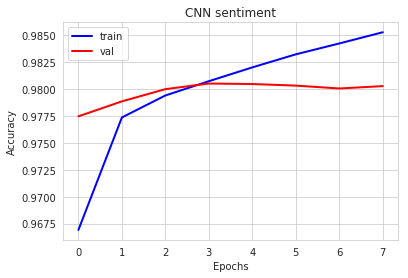

In [45]:
plt.figure()
plt.plot(hist.history['acc'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_acc'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()